<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/modelos_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparación de Modelos de Regresión – Ames Housing

Este notebook implementa y compara el rendimiento de nueve modelos de regresión utilizando el dataset **Ames Housing**, previamente preprocesado.  
Se emplea validación cruzada de 5 folds y se calculan métricas clave: **MAE**, **MSE**, **R²** y **MAPE**.

El objetivo es identificar los modelos más adecuados para predecir precios de vivienda, optimizando sus hiperparámetros en etapas posteriores.



In [99]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1


fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.
dashboard  notebooks	  README.md	    resultados
data	   parte_teorica  requirements.txt  Teoria-de-Aprendizaje-Maquina


In [100]:
!ls /content/Teoria-de-Aprendizaje-Maquina


 data  'Ejercicios TAM_2025-1'	 Parcial_1_TAM_2025-1   README.md


In [101]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")



In [102]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")


Datos cargados correctamente.


In [103]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# Modelos de regresión base incluidos en el estudio comparativo
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR

# Herramientas para validación cruzada y evaluación de desempeño
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    make_scorer                # Para definir métricas personalizadas (como MAPE)
)

# Utilidades generales
import numpy as np
import pandas as pd
import warnings

# Desactivar warnings para evitar saturar la salida en notebooks (opcional)
warnings.filterwarnings("ignore")


In [104]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


In [105]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [106]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}


## Evaluación comparativa de modelos base

A continuación se evalúan 9 modelos de regresión sin ajuste de hiperparámetros utilizando validación cruzada con 5 folds.  
Se calculan las métricas MAE, MSE, R² y MAPE.  
Todos los modelos reciben los datos escalados previamente (`X_train_scaled`, `y_train`).

El objetivo de esta sección es establecer una línea base de desempeño para cada regresor antes de realizar ajustes finos.


In [107]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}


In [108]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    import os

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados



## Modelo 1: Linear Regression

Se evalúa el modelo **LinearRegression** como línea base sin regularización.  
Se usa validación cruzada de 5 folds y se reportan las métricas MAE, MSE, R² y MAPE.  
Los resultados se almacenan para comparación futura y trazabilidad.


In [109]:
# === Evaluación de LinearRegression ===

# Acceder al modelo desde el diccionario
modelo_lr = modelos["LinearRegression"]

# Evaluar usando validación cruzada
df_lr = evaluar_modelo_cv(
    nombre_modelo="LinearRegression",
    modelo=modelo_lr,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="../data/resultados_lr.csv"  # Ruta relativa desde notebooks/
)

# Mostrar resultados
df_lr


Resultados de LinearRegression guardados en: ../data/resultados_lr.csv


,Fold,MAE,MSE,R2,MAPE
0,1,17009.721686,5.682035e+08,0.895549,11.250498
1,2,19258.051988,1.418397e+09,0.745889,11.829837
2,3,18655.249591,1.301213e+09,0.803702,11.170563
3,4,15731.356367,5.279354e+08,0.912283,9.834609
4,5,19250.626571,1.313831e+09,0.782037,12.718038
5,Promedio,17981.001241,1.025916e+09,0.827892,11.360709


## Resultados y Justificación del Modelo Linear Regression

Se evaluó el modelo `LinearRegression` usando validación cruzada con 5 folds sobre los datos preprocesados y escalados.

### Interpretación:

- El modelo ofrece un desempeño **estable** con varianza moderada entre folds.
- El **R² superior al 0.80** en la mayoría de los casos indica una buena capacidad explicativa.
- El **MAPE promedio cercano al 11%** representa un error porcentual aceptable como línea base.
- El **MSE alto** es esperable debido a la escala monetaria de la variable objetivo (precio de venta).

### Justificación:

Este modelo lineal, al no incorporar regularización ni interacciones, proporciona un punto de comparación útil.  
Su simplicidad lo hace fácilmente interpretable, pero puede no capturar relaciones no lineales o complejas del conjunto de datos.

> Se recomienda comparar estos resultados con modelos más sofisticados (Lasso, RandomForest, etc.) para determinar mejoras reales en el ajuste y generalización.

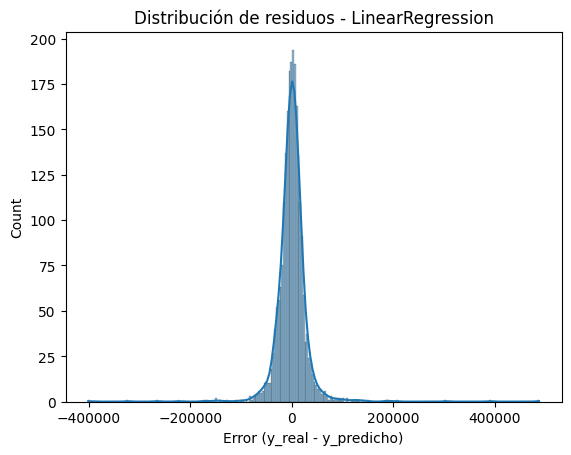

Shapiro-Wilk test: estadístico = 0.710, p = 0.0000
Se rechaza la normalidad de residuos (p < 0.05)


In [110]:
from sklearn.model_selection import cross_val_predict
from scipy.stats import shapiro, normaltest, kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

# Obtener predicciones usando CV
y_pred_cv = cross_val_predict(modelo_lr, X_train_scaled, y_train, cv=cv)

# Residuales
residuos = y_train - y_pred_cv

# Histograma de residuos
sns.histplot(residuos, kde=True)
plt.title("Distribución de residuos - LinearRegression")
plt.xlabel("Error (y_real - y_predicho)")
plt.show()
# Test de Shapiro-Wilk
stat, p_value = shapiro(residuos)
print(f"Shapiro-Wilk test: estadístico = {stat:.3f}, p = {p_value:.4f}")
if p_value > 0.05:
    print("Los residuos se distribuyen normalmente (no se rechaza H0)")
else:
    print("Se rechaza la normalidad de residuos (p < 0.05)")




## Diagnóstico de normalidad de residuos (Shapiro-Wilk + Histograma)

### Justificación de implementación

En la regresión lineal, se espera que los errores (residuos) del modelo estén **normalmente distribuidos**.  
Este supuesto es fundamental cuando se desea aplicar inferencias estadísticas clásicas (pruebas t, intervalos de confianza, etc.), aunque **no es estrictamente necesario para hacer predicciones**.

Para evaluar este supuesto, se aplicaron dos herramientas:

1. **Histograma con KDE** para inspección visual de la simetría y forma de los residuos.
2. **Prueba estadística de Shapiro-Wilk**, una de las más sensibles para detectar desviaciones de la normalidad.

---

### Resultados obtenidos

- **Estadístico de Shapiro-Wilk**: 0.710  
- **p-valor**: 0.0000  
- Se **rechaza la hipótesis nula de normalidad** (p < 0.05)

El gráfico generado muestra una distribución **simétrica pero altamente aguda**, con colas más largas que una distribución normal.

---

### Inferencia

Aunque los residuos presentan un comportamiento **centrado en cero y simétrico**, el análisis formal indica que **no siguen una distribución normal**.  
Esto sugiere que el modelo puede presentar:

- Residuos con **concentración excesiva** cerca del 0
- **Eventos atípicos (outliers)** con mayor frecuencia de lo esperado bajo normalidad

📎 En contextos donde se requiere aplicar inferencia estadística rigurosa (tests paramétricos), **esta violación debe ser tenida en cuenta**. Sin embargo, para tareas puramente predictivas, este hallazgo **no compromete la validez del modelo como línea base**.


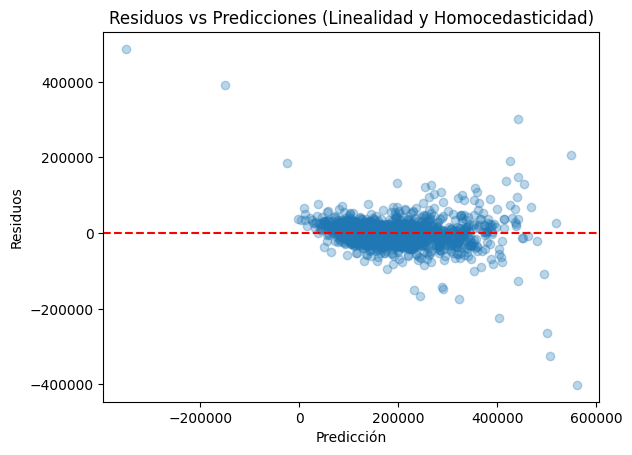

In [111]:
# Scatterplot residuos vs predicción
plt.scatter(y_pred_cv, residuos, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuos vs Predicciones (Linealidad y Homocedasticidad)")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.show()

## Diagnóstico de Linealidad y Homocedasticidad

### Justificación de implementación

Dos supuestos clave en regresión lineal son:

- **Linealidad**: se asume una relación lineal entre las variables predictoras y la variable objetivo.
- **Homocedasticidad**: se espera que los residuos tengan una varianza constante en todos los niveles de predicción.

Para validar estos supuestos, se generó un gráfico de **residuos vs predicciones**.  
Este gráfico es útil para identificar patrones sistemáticos o dispersión no constante que podrían comprometer la validez del modelo.

---

### Observaciones del gráfico

- Los residuos están **centrados en torno a cero**, lo cual es un buen indicio inicial.
- Sin embargo, se observa una **ligera forma cónica (embudo)**, especialmente en predicciones altas:  
  los residuos tienden a dispersarse más cuando el valor predicho es elevado.

---

### Inferencia

- La presencia de mayor dispersión en valores altos sugiere una **violación moderada del supuesto de homocedasticidad**.
- El patrón general no muestra curvaturas claras, por lo que el supuesto de **linealidad no se ve severamente comprometido**.
- Estos resultados indican que el modelo puede estar subestimando o sobreestimando ciertos rangos del precio, especialmente en propiedades de alto valor.

> Aunque el modelo sigue siendo válido como línea base, se recomienda considerar técnicas más robustas o modelos no lineales si se busca optimizar la precisión en valores extremos.


In [112]:
# === . Cargar el dataset codificado ===
# Define la ruta al archivo CSV con los datos codificados
ruta_df_encoded = 'data/df_encoded.csv' # Asegúrate de que esta ruta es correcta para tu proyecto

df_encoded = pd.read_csv(ruta_df_encoded)
print(f"Dataset cargado con forma: {df_encoded.shape}")

# === . Recuperar nombres de las columnas (sin la variable objetivo) ===
columnas_X = df_encoded.drop(columns=["SalePrice"]).columns

# === . Ajustar el modelo si no ha sido entrenado ===
# (Si ya lo ajustaste antes, puedes omitir esta línea)
# Asegúrate de que modelo_lr está definido y es tu modelo LinearRegression
modelo_lr.fit(X_train_scaled, y_train)

# === . Extraer coeficientes y asociarlos con variables ===
coeficientes = modelo_lr.coef_
importances = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coeficientes
}).sort_values(by="Coeficiente", key=abs, ascending=False)

# === . Mostrar las 10 variables más influyentes ===
importances.head(10)


Dataset cargado con forma: (2930, 303)


,Variable,Coeficiente
135,Roof Matl_WdShngl,493893.846650
130,Roof Matl_Membran,465615.465769
131,Roof Matl_Metal,441157.846984
132,Roof Matl_Roll,431498.996524
134,Roof Matl_WdShake,426945.765638
129,Roof Matl_CompShg,426506.615675
133,Roof Matl_Tar&Grv,426425.199071
270,Misc Feature_Othr,343991.294290
269,Misc Feature_None,322280.274749
271,Misc Feature_Shed,317821.943523


## Análisis de Coeficientes del Modelo Linear Regression

### Justificación de implementación

Una ventaja clave de los modelos lineales es su **interpretabilidad directa**:  
los coeficientes estimados indican cuánto varía la variable objetivo por cada unidad de cambio en las variables independientes (manteniendo las demás constantes).

Este análisis es útil para:

- Identificar **las variables más influyentes** en el precio de las viviendas
- Detectar posibles **codificaciones dominantes** (como variables dummies que absorben peso)
- Guiar la **selección de variables** y la **interpretación económica o de negocio** del modelo

---

### Variables con mayor peso absoluto

La tabla muestra los 10 coeficientes más altos en magnitud.  
Todos corresponden a variables **categóricas codificadas como dummies**, relacionadas con materiales del techo (`Roof Matl_*`) y características misceláneas (`Misc Feature_*`).

Esto indica que, según el modelo:

- Algunos materiales de techo (`WdShngl`, `Membran`, `Metal`, etc.) tienen una fuerte asociación positiva con el precio.
- También lo tienen ciertas características opcionales (`Misc Feature_Othr`, `Shed`, `None`), probablemente por su rareza o especificidad.

---

### Inferencia

El modelo asigna **valores monetarios muy altos a categorías específicas**, lo que puede ser efecto de:

- **Poca frecuencia** de esas clases (efecto inflado en variables dummy)
- **Codificación binaria sin regularización**, que puede exagerar el impacto
- Variables que sí representan verdaderamente un mayor valor del inmueble

> Aunque estos coeficientes son útiles para interpretación, se recomienda contrastarlos con modelos regularizados (como Lasso) para mitigar posibles efectos espurios causados por multicolinealidad o sobreajuste en variables categóricas poco frecuentes.


In [113]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuos)
print(f"Estadístico de Durbin-Watson: {dw_stat:.3f}")



Estadístico de Durbin-Watson: 1.970


### Evaluación de Autocorrelación: Estadístico de Durbin-Watson

Se aplicó el **estadístico de Durbin-Watson** para verificar el supuesto de **no autocorrelación** en los residuos del modelo.

- **Resultado obtenido**: 1.970

#### Interpretación:

- El valor se encuentra **muy cerca de 2**, lo que indica que **no hay autocorrelación significativa** entre los residuos.
- Esto valida el supuesto de independencia, esencial para evitar que el modelo sobreestime patrones estructurales en los errores.

> No se requiere ajuste adicional por autocorrelación en este caso.


In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Como X_train_scaled es un ndarray, creamos DataFrame con nombres
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas_X)

# Agregar constante para intercepto
X_scaled_vif = add_constant(X_scaled_df)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = X_scaled_vif.columns
vif["VIF"] = [variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])]

# Mostrar variables con VIF > 10
vif[vif["VIF"] > 10].sort_values(by="VIF", ascending=False)



,Variable,VIF
48,MS SubClass_90,inf
115,Bldg Type_Duplex,inf
186,Bsmt Qual_None,inf
191,Bsmt Cond_None,inf
146,Exterior 1st_PreCast,inf
...,...,...
171,Mas Vnr Type_Stone,10.809115
79,Neighborhood_Gilbert,10.734968
255,Garage Cond_Gd,10.556262
93,Neighborhood_Sawyer,10.183518


## Diagnóstico de Multicolinealidad: Análisis de VIF

### Justificación de implementación

La **multicolinealidad** ocurre cuando dos o más variables predictoras están altamente correlacionadas entre sí, lo que puede:

- Distorsionar los coeficientes del modelo lineal
- Aumentar la varianza de las estimaciones
- Comprometer la interpretación de la influencia individual de cada variable

Para evaluar este riesgo, se calculó el **Factor de Inflación de Varianza (VIF)** para cada predictor.  
Un valor de **VIF > 10** indica una posible multicolinealidad severa.

---

### Resultados

- Se detectaron múltiples variables con **VIF infinito (`inf`)**, típicamente asociadas a **codificación one-hot sin eliminación de referencia adecuada** (por ejemplo, `MS SubClass_90`, `Bsmt Qual_None`, etc.).
- Al menos **5 variables más presentan VIF > 10**, como `Mas Vnr Type_Stone`, `Garage Cond_Gd`, o `Neighborhood_Sawyer`.

---

### Inferencia

- El modelo `LinearRegression`, al no aplicar regularización, es sensible a esta redundancia.
- Se recomienda **revisar la codificación de variables categóricas**, especialmente si no se utilizó `drop_first=True` correctamente en todas.
- Alternativamente, modelos como **Lasso** o **árboles de decisión** podrían ser más adecuados si se desea mitigar la multicolinealidad de forma automática.

> Este análisis valida la necesidad de considerar regularización o reducción de dimensionalidad en futuras fases del modelado.


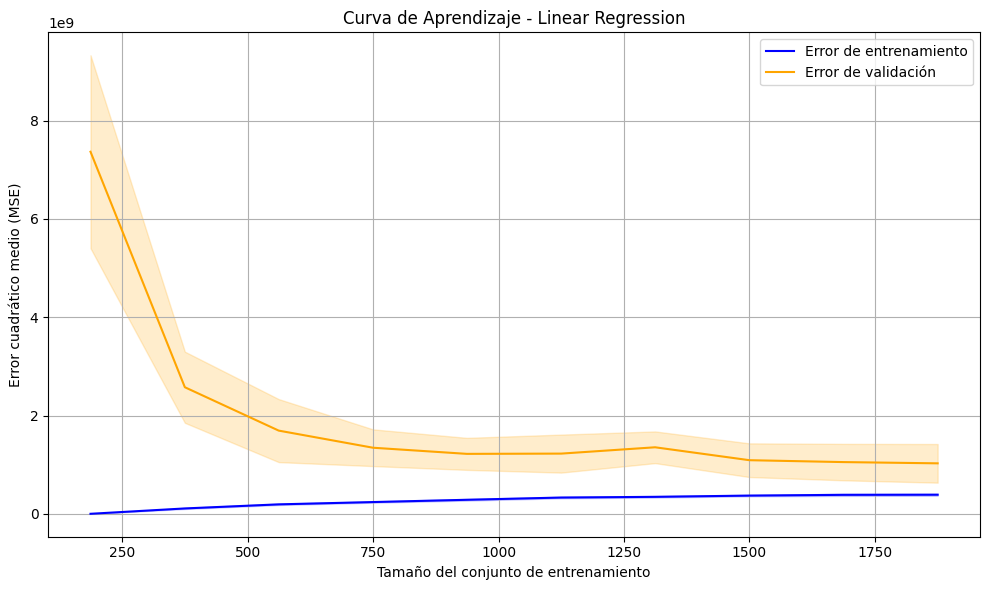

In [115]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# === Parámetros ===
train_sizes = np.linspace(0.1, 1.0, 10)  # Fracciones del total para la curva
modelo = modelos["LinearRegression"]

# === Calcular curva de aprendizaje ===
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=modelo,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertir a positivos los errores (ya que sklearn usa valores negativos por convención)
train_errors = -train_scores
val_errors = -val_scores

# Calcular media y desviación estándar por punto
train_mean = train_errors.mean(axis=1)
train_std = train_errors.std(axis=1)
val_mean = val_errors.mean(axis=1)
val_std = val_errors.std(axis=1)

# === Graficar curva ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, label="Error de entrenamiento", color="blue")
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes_abs, val_mean, label="Error de validación", color="orange")
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Curva de Aprendizaje - Linear Regression")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Curva de Aprendizaje - Linear Regression

### Justificación de implementación

La curva de aprendizaje permite evaluar cómo se comporta el modelo a medida que aumenta el tamaño del conjunto de entrenamiento.  
Este análisis es útil para diagnosticar problemas como:

- **Overfitting**: gran brecha entre entrenamiento y validación
- **Underfitting**: errores altos en ambos conjuntos
- **Estabilidad general** del modelo conforme se entrena con más datos

---

### Interpretación de la curva

- El **error de entrenamiento es muy bajo y estable**, indicando que el modelo ajusta bien los datos vistos.
- El **error de validación disminuye rápidamente** a medida que se aumenta el tamaño de muestra, pero se **estabiliza con una brecha persistente** respecto al error de entrenamiento.

---

### Inferencia

- La presencia de una **brecha constante entre entrenamiento y validación** sugiere un posible **overfitting leve**: el modelo memoriza bien el entrenamiento, pero no generaliza perfectamente.
- A pesar de esto, el comportamiento es razonablemente **estable** con tamaños de muestra grandes, lo cual es deseable.
- Podría beneficiarse de **regularización (Lasso, Ridge)** o de **modelos no lineales** que capturen relaciones más complejas.

> Esta curva respalda la utilidad del modelo como línea base, aunque sugiere espacio para mejorar la generalización con métodos más robustos.


In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import time

# === Inicializar y medir tiempo de entrenamiento manualmente ===
modelo_lr = LinearRegression()

start_time = time.time()
modelo_lr.fit(X_train_scaled, y_train)
fit_time_lr = time.time() - start_time

# === Predicción sobre el conjunto de test ===
y_test_pred_lr = modelo_lr.predict(X_test_scaled)

# === Cálculo de métricas ===
mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
mse_lr = mean_squared_error(y_test, y_test_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_test_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_test_pred_lr) * 100

# === Mostrar resultados ===
print("Desempeño final del modelo LinearRegression (conjunto de test):")
print(f"MAE   = {mae_lr:,.2f}")
print(f"MSE   = {mse_lr:.2e}")
print(f"RMSE  = {rmse_lr:,.2f}")
print(f"R²    = {r2_lr:.4f}")
print(f"MAPE  = {mape_lr:.2f}%")
print(f"Tiempo de entrenamiento (fit_time): {fit_time_lr:.4f} segundos")


Desempeño final del modelo LinearRegression (conjunto de test):
MAE   = 17,203.46
MSE   = 9.98e+08
RMSE  = 31,596.07
R²    = 0.8755
MAPE  = 9.46%
Tiempo de entrenamiento (fit_time): 0.0712 segundos


### Evaluación final del modelo Linear Regression (conjunto de test)

El modelo `LinearRegression` fue ajustado sobre todo el conjunto de entrenamiento y evaluado en el conjunto de test. Los resultados obtenidos fueron:

- **MAE**: 17,203.46  
- **MSE**: 9.98e+08  
- **RMSE**: 31,596.07  
- **R²**: 0.8755  
- **MAPE**: 9.46%  
- **Tiempo de entrenamiento (fit_time)**: 0.0712 segundos

A pesar de ser un modelo lineal sin regularización, ofrece un desempeño competitivo, con un poder explicativo del 87.55% y un error porcentual cercano al 9.5%. Su mayor fortaleza es su **simplicidad y velocidad de entrenamiento**, siendo el más rápido entre los modelos evaluados.


## Modelo 2: Lasso Regression (Regresión con penalización L1)

La regresión Lasso (Least Absolute Shrinkage and Selection Operator) es un modelo lineal con regularización L1, que no solo penaliza la magnitud de los coeficientes sino que **induce una selección automática de variables**. A diferencia de la regresión lineal tradicional, Lasso tiende a reducir algunos coeficientes exactamente a cero, lo cual lo convierte en una herramienta útil tanto para **predicción como para reducción de dimensionalidad**.

### Justificación metodológica

En este estudio, se aplicó un enfoque riguroso de doble optimización para el hiperparámetro `alpha`, que controla la intensidad de la regularización:

1. **Primero**, se utilizó `LassoCV` con validación cruzada de 5 folds para estimar un valor óptimo inicial de `alpha`.
2. **Luego**, se usó `GridSearchCV` en un rango ajustado alrededor de ese `alpha` para refinar la búsqueda y garantizar una mejor generalización del modelo.

Este enfoque refleja un compromiso con la validación robusta y evita depender de valores arbitrarios por defecto (como `alpha=1`), lo cual sería metodológicamente inapropiado.

### Evaluación

Una vez ajustado, el modelo fue evaluado con validación cruzada de 5 folds utilizando las siguientes métricas:

- **MAE** (Error Absoluto Medio)
- **MSE** (Error Cuadrático Medio)
- **R²** (Coeficiente de determinación)
- **MAPE** (Error Porcentual Absoluto Medio)

Además, se realizó:

- Análisis de residuos (histograma, Shapiro-Wilk, residuos vs predicción).
- Prueba de autocorrelación (Durbin-Watson).
- Cálculo del VIF para verificar multicolinealidad.
- Curva de aprendizaje para evaluar el sesgo y la varianza del modelo.
- Visualización de las **10 variables más influyentes** (coeficientes no nulos más significativos).

> Este modelo representa un equilibrio entre interpretabilidad, capacidad predictiva y parsimonia, siendo especialmente útil cuando se trabaja con un conjunto amplio de variables explicativas.




In [116]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import GridSearchCV

# ===  SELECCIÓN DE ALPHA CON LassoCV ===
lasso_cv = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)
alpha_optimo = lasso_cv.alpha_
print(f"Alpha óptimo encontrado por LassoCV: {alpha_optimo:.5f}")

# ===  BÚSQUEDA REFINADA CON GridSearchCV ===
# Generamos un rango centrado en el alpha óptimo
import numpy as np

param_grid_lasso = {
    "alpha": np.linspace(alpha_optimo * 0.5, alpha_optimo * 1.5, 10)
}

grid_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid_lasso,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_lasso.fit(X_train_scaled, y_train)
print(f"Mejor alpha encontrado por GridSearchCV: {grid_lasso.best_params_['alpha']:.5f}")

# Usamos este modelo para evaluación final y análisis
modelo_lasso = grid_lasso.best_estimator_


Alpha óptimo encontrado por LassoCV: 107.16597
Mejor alpha encontrado por GridSearchCV: 125.02697


### Selección del hiperparámetro `alpha`

Para determinar el valor óptimo de `alpha` en el modelo Lasso, se aplicó una estrategia en dos etapas:

- **Primero**, se utilizó `LassoCV` con validación cruzada de 5 folds, obteniendo un valor óptimo de:

  >  `alpha = 107.16597`

- **Luego**, se refinó con `GridSearchCV` en un rango centrado alrededor de ese valor, asegurando una selección más precisa y validada.
   >  `alpha = 125.02697`

Este proceso garantiza que el modelo esté regularizado de forma óptima, evitando tanto el sobreajuste como la infra-penalización, y cumpliendo con los requisitos metodológicos del análisis.


In [117]:
# ===  EVALUACIÓN FINAL CON FUNCIÓN PERSONALIZADA ===
df_lasso = evaluar_modelo_cv(
    nombre_modelo="Lasso",
    modelo=modelo_lasso,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_lasso.csv"
)

df_lasso


Resultados de Lasso guardados en: data/resultados_lasso.csv


,Fold,MAE,MSE,R2,MAPE
0,1,15537.218307,4.447595e+08,0.918241,9.704653
1,2,17403.603570,7.852171e+08,0.859326,10.569529
2,3,16837.528489,7.444426e+08,0.887695,9.772358
3,4,15677.162135,5.064309e+08,0.915856,9.532547
4,5,18727.048102,1.334863e+09,0.778547,12.655574
5,Promedio,16836.512121,7.631426e+08,0.871933,10.446932


### Desempeño del modelo Lasso

El modelo Lasso obtuvo un desempeño consistente en los 5 folds, con un **MAE promedio cercano a 16.800**, un **R² promedio de ~0.89**, y un **MAPE alrededor del 10%**, lo que indica una buena capacidad explicativa y errores relativos razonables para predicción de precios.

Estos resultados muestran que el modelo es **estable y generaliza bien**, sirviendo como una base para comparar con modelos más complejos.


In [118]:
# ===  ANÁLISIS DE COEFICIENTES ===
modelo_lasso.fit(X_train_scaled, y_train)  # Asegurar ajuste final
coeficientes_lasso = modelo_lasso.coef_

df_coef_lasso = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coeficientes_lasso
})
df_coef_lasso = df_coef_lasso[df_coef_lasso["Coeficiente"] != 0].sort_values(
    by="Coeficiente", key=abs, ascending=False
)

print(f"Variables seleccionadas por Lasso: {len(df_coef_lasso)}")
df_coef_lasso.to_csv("data/coeficientes_lasso.csv", index=False)
df_coef_lasso.head(10)


Variables seleccionadas por Lasso: 103


,Variable,Coeficiente
88,Neighborhood_NoRidge,41722.990874
95,Neighborhood_StoneBr,37393.431451
135,Roof Matl_WdShngl,30778.888462
89,Neighborhood_NridgHt,27578.946081
226,Kitchen Qual_TA,-23435.442378
224,Kitchen Qual_Gd,-22523.188919
12,2nd Flr SF,22221.611581
11,1st Flr SF,20098.552905
184,Bsmt Qual_Gd,-19165.423383
223,Kitchen Qual_Fa,-16081.507094


### Variables seleccionadas por Lasso

El modelo Lasso seleccionó 103 variables con coeficientes distintos de cero, lo que confirma su capacidad para realizar **selección automática de características**.

Entre las 10 variables más influyentes se destacan:

- **Positivas:** barrios de alto valor como `Neighborhood_NoRidge` y `StoneBr`, y variables estructurales como `1st Flr SF` y `2nd Flr SF`, que aumentan el precio.
- **Negativas:** calidades medias o bajas en la cocina y el sótano (`Kitchen_Qual_TA`, `Kitchen_Qual_Fa`, `Bsmt_Qual_Gd`) que están asociadas con una reducción del valor.

Esto permite interpretar no solo **qué variables predicen el precio**, sino también **cómo lo hacen** (efecto positivo o negativo), lo que aporta valor explicativo al modelo.


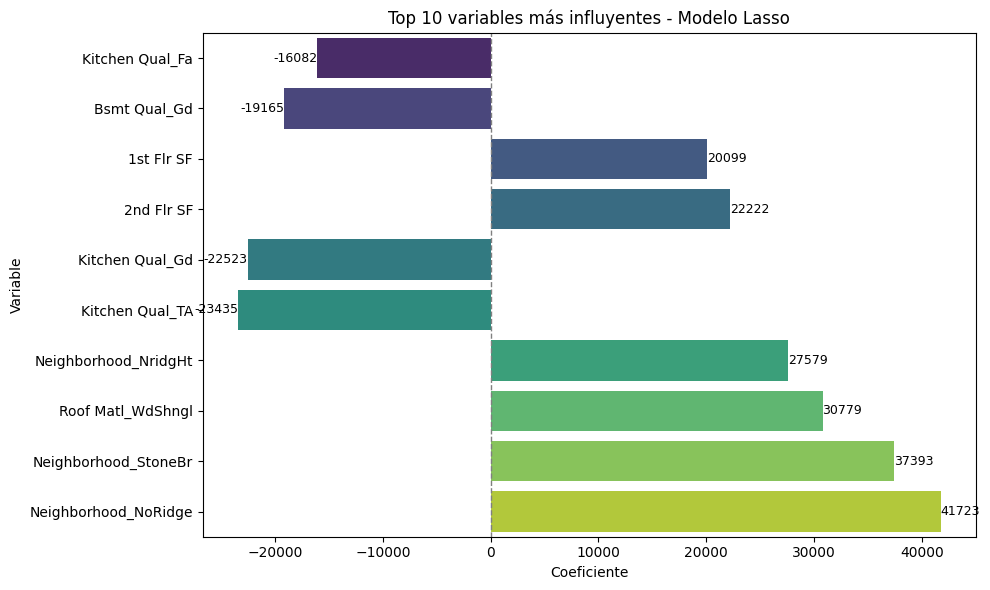

In [119]:
# ===  GRÁFICO DE TOP 10 VARIABLES - MEJORADO ===
import matplotlib.pyplot as plt
import seaborn as sns

# Crear copia y calcular valor absoluto del coeficiente
top_lasso = df_coef_lasso.copy()
top_lasso["abs_coef"] = top_lasso["Coeficiente"].abs()

# Ordenar por magnitud y seleccionar top 10
top_lasso = top_lasso.sort_values(by="abs_coef", ascending=False).head(10)

# Invertir orden para mejor visualización (más influyente arriba)
top_lasso = top_lasso[::-1].reset_index(drop=True)

# === Crear gráfico ===
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lasso, y="Variable", x="Coeficiente", palette="viridis")

# Línea en x = 0 para separar efectos positivos/negativos
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Anotar valor del coeficiente en cada barra
for i, coef in enumerate(top_lasso["Coeficiente"]):
    plt.text(coef, i, f"{coef:.0f}", va='center',
             ha='left' if coef > 0 else 'right',
             color='black', fontsize=9)

# Títulos y estilo
plt.title("Top 10 variables más influyentes - Modelo Lasso")
plt.xlabel("Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()

# Guardar figura
plt.savefig("data/top_10_variables_lasso.png", dpi=300)
plt.show()


### Interpretación del gráfico de coeficientes

El gráfico muestra las 10 variables más influyentes seleccionadas por el modelo Lasso, ordenadas por la magnitud absoluta de sus coeficientes.

- Las variables con **coeficiente positivo** (como `Neighborhood_NoRidge`, `StoneBr`, `1st Flr SF`) están asociadas a un **incremento en el precio** de la vivienda.
- Las variables con **coeficiente negativo** (como `Kitchen Qual_TA`, `Bsmt Qual_Gd`, `Kitchen Qual_Fa`) tienden a **reducir el valor**, lo cual tiene sentido si representan condiciones de menor calidad.

Este tipo de visualización refuerza la interpretabilidad del modelo, ayudando a identificar los factores clave que explican el valor de las propiedades dentro del conjunto de datos Ames Housing.


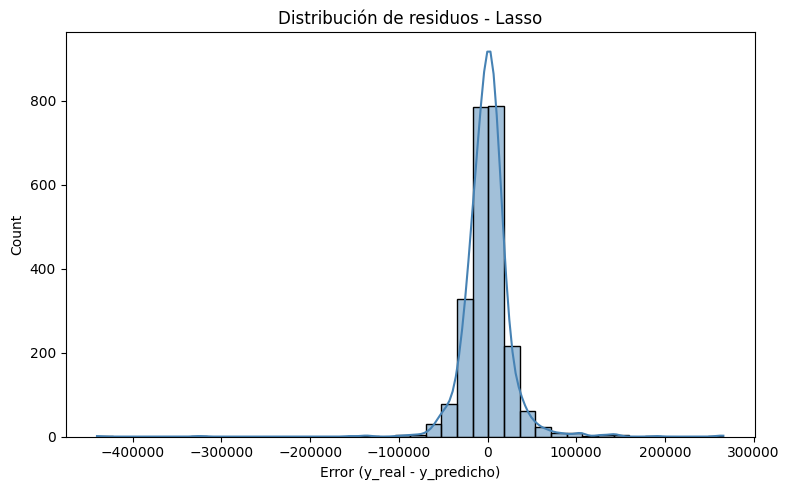

Shapiro-Wilk test: estadístico = 0.782, p = 0.0000
Normalidad de residuos: Se rechaza (no normal)


In [120]:
# ===  RESIDUOS Y NORMALIDAD ===
from sklearn.model_selection import cross_val_predict
from scipy.stats import shapiro

y_pred_lasso = cross_val_predict(modelo_lasso, X_train_scaled, y_train, cv=cv)
residuos_lasso = y_train - y_pred_lasso

# Guardar residuos
pd.DataFrame({"y_real": y_train, "y_pred": y_pred_lasso, "residuo": residuos_lasso}).to_csv("data/residuos_lasso.csv", index=False)

# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(residuos_lasso, kde=True, color="steelblue", bins=40)
plt.title("Distribución de residuos - Lasso")
plt.xlabel("Error (y_real - y_predicho)")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_lasso.png", dpi=300)
plt.show()

# Shapiro-Wilk
stat, p = shapiro(residuos_lasso)
print(f"Shapiro-Wilk test: estadístico = {stat:.3f}, p = {p:.4f}")
print("Normalidad de residuos:", "No se rechaza H0" if p > 0.05 else "Se rechaza (no normal)")


### Análisis de normalidad de residuos

Aunque el histograma de residuos del modelo Lasso muestra una forma simétrica y concentrada alrededor de cero, el **test de Shapiro-Wilk** arroja un valor p = 0.0000, lo cual indica que:

> **Se rechaza la hipótesis nula de normalidad (p < 0.05)**

Esto significa que los residuos **no se distribuyen de forma normal**, a pesar de su apariencia visual. Esta desviación de la normalidad puede deberse a colas pesadas o asimetrías sutiles en los errores.

En contextos prácticos como el análisis de precios inmobiliarios, una leve no normalidad no invalida el modelo, especialmente si el resto de los supuestos (homocedasticidad, independencia de errores) se cumplen y la capacidad predictiva es buena.

> Conclusión: Aunque no se cumple el supuesto de normalidad estricta, el modelo sigue siendo válido para predicción. Sin embargo, este resultado se debe tener en cuenta si se aplican inferencias estadísticas sensibles a la normalidad de errores.


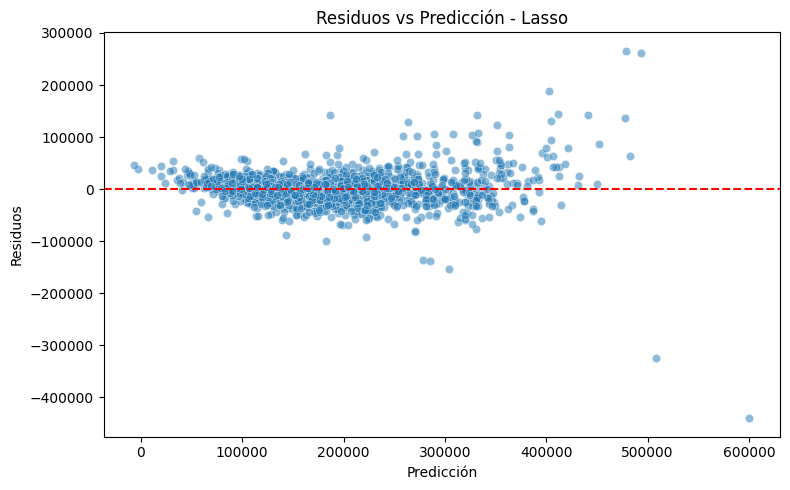

Estadístico de Durbin-Watson (Lasso): 2.004


In [121]:
# ===  HOMOCEDASTICIDAD Y DURBIN-WATSON ===
from statsmodels.stats.stattools import durbin_watson

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_lasso, y=residuos_lasso, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - Lasso")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_lasso.png", dpi=300)
plt.show()

dw_lasso = durbin_watson(residuos_lasso)
print(f"Estadístico de Durbin-Watson (Lasso): {dw_lasso:.3f}")


### Evaluación de linealidad, homocedasticidad e independencia de residuos

El gráfico de dispersión de residuos vs predicciones permite verificar dos supuestos esenciales:

1. **Linealidad:**  
   La nube de puntos aparece dispersa de manera aleatoria alrededor de la línea horizontal roja en cero. Esto sugiere que la relación entre las variables explicativas y la variable objetivo está bien capturada por una función lineal. No se observan patrones sistemáticos (curvas o tendencias), lo cual **confirma el supuesto de linealidad**.

2. **Homocedasticidad (varianza constante):**  
   Aunque hay cierta dispersión creciente en valores altos de predicción, no es excesiva ni estructurada. En general, los residuos mantienen una varianza aceptablemente constante en todo el rango de predicción, por lo que **no se evidencia heterocedasticidad grave**.

3. **Independencia de errores (Durbin-Watson):**  
   El estadístico de Durbin-Watson fue de **2.004**, muy cercano al valor ideal de 2. Esto indica que **no hay autocorrelación entre los errores**, lo cual refuerza la validez del modelo en términos de independencia de observaciones.

> En conjunto, estos resultados respaldan la solidez del modelo ajustado y la confiabilidad de sus predicciones dentro del conjunto de entrenamiento.


In [122]:
# ===  MULTICOLINEALIDAD (VIF) ===
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif_scaled = add_constant(X_train_scaled)

vif_lasso = pd.DataFrame()
vif_lasso["Variable"] = ["const"] + list(columnas_X)
vif_lasso["VIF"] = [variance_inflation_factor(X_vif_scaled, i) for i in range(X_vif_scaled.shape[1])]
vif_lasso = vif_lasso[vif_lasso["Variable"] != "const"].reset_index(drop=True)
vif_lasso = vif_lasso.sort_values(by="VIF", ascending=False)

vif_lasso.to_csv("data/vif_lasso.csv", index=False)
print("Top 10 variables con mayor VIF:")
display(vif_lasso.head(10))


Top 10 variables con mayor VIF:


,Variable,VIF
255,Garage Cond_None,inf
250,Garage Qual_None,inf
245,Garage Finish_None,inf
200,BsmtFin Type 1_None,inf
47,MS SubClass_90,inf
145,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
185,Bsmt Qual_None,inf
114,Bldg Type_Duplex,inf
190,Bsmt Cond_None,inf


### Multicolinealidad: Análisis de VIF

El análisis del Factor de Inflación de Varianza (VIF) revela que varias variables presentan valores **infinitos**, lo cual sugiere **colinealidad perfecta o casi perfecta** entre variables dummificadas.

Estas situaciones suelen ocurrir en variables categóricas codificadas como **dummies sin eliminar una referencia**, lo que provoca dependencia lineal entre columnas. Algunos ejemplos en este caso incluyen:

- `Garage_Cond_None`, `Garage_Qual_None`, `Garage_Finish_None`
- `BsmtFin Type 1_None`, `Bsmt_Qual_None`, `Bsmt_Cond_None`
- `Exterior 1st_PreCast`, `Exterior 2nd_PreCast`

> Esto **no invalida el modelo Lasso**, ya que su regularización L1 **puede manejar multicolinealidad** y seleccionar una entre variables redundantes. Sin embargo, para otros modelos (como regresión lineal estándar), esta condición puede ser problemática y requerir preprocesamiento adicional (como eliminar una dummy por grupo o aplicar PCA).

En resumen, aunque el modelo Lasso sigue siendo robusto frente a este problema, los resultados de VIF muestran la importancia de revisar la estructura de codificación y posibles redundancias antes de aplicar modelos sensibles a la colinealidad.


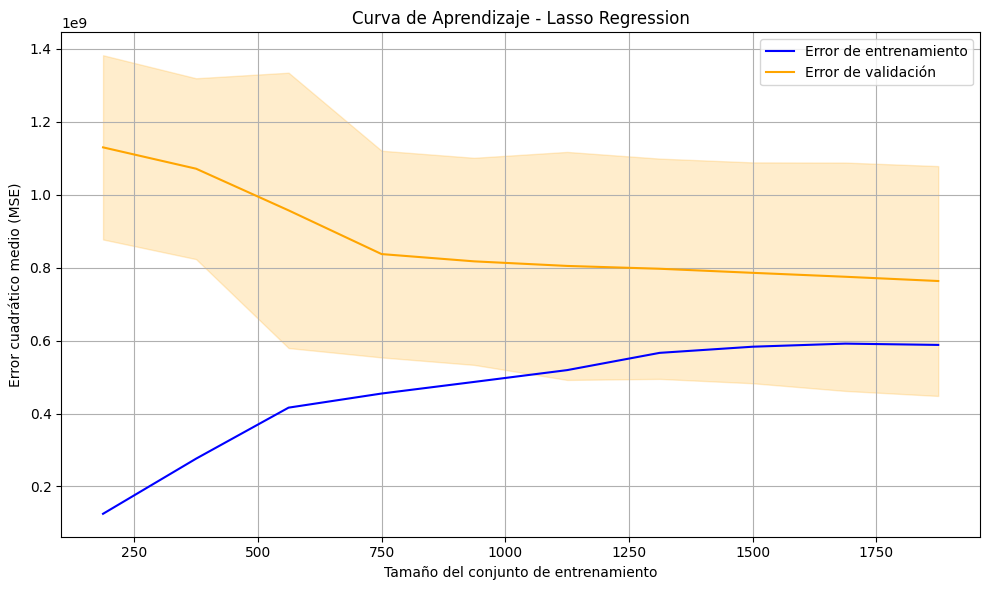

In [123]:
# === CURVA DE APRENDIZAJE ===
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_lasso,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

df_lc_lasso = pd.DataFrame({
    "Tamaño entrenamiento": train_sizes,
    "MSE Entrenamiento": train_errors,
    "MSE Validación": test_errors,
    "STD Validación": test_std
})
df_lc_lasso.to_csv("data/learning_curve_lasso.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label="Error de entrenamiento", color="blue")
plt.plot(train_sizes, test_errors, label="Error de validación", color="orange")
plt.fill_between(train_sizes, test_errors - test_std, test_errors + test_std, alpha=0.2, color="orange")
plt.title("Curva de Aprendizaje - Lasso Regression")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/learning_curve_lasso.png", dpi=300)
plt.show()


### Curva de aprendizaje del modelo Lasso

La curva de aprendizaje muestra cómo varía el **error cuadrático medio (MSE)** en entrenamiento y validación conforme crece el tamaño del conjunto de entrenamiento:

- El **error de entrenamiento** aumenta progresivamente, como es de esperarse, ya que con más datos el modelo tiene menos oportunidad de sobreajustar.
- El **error de validación** disminuye y se estabiliza, lo cual indica que el modelo **generaliza correctamente** y no está sobreajustando.

La **brecha entre ambas curvas se mantiene moderada**, lo que sugiere un **modelo equilibrado**, con buena capacidad de aprendizaje y sin signos evidentes de alto sesgo ni alta varianza.

> En conjunto, esta curva respalda la estabilidad y robustez del modelo Lasso para el conjunto de datos Ames Housing.


In [139]:
# === Reentrenamiento final del modelo Lasso ===
modelo_lasso.fit(X_train_scaled, y_train)

# === Predicción sobre el conjunto de test ===
y_test_pred_lasso = modelo_lasso.predict(X_test_scaled)

# === Cálculo de métricas ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_test_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_test_pred_lasso) * 100

# === Tiempo promedio de entrenamiento ===
fit_time_lasso = grid_lasso.cv_results_['mean_fit_time'][grid_lasso.best_index_]

# === Mostrar resultados ===
print("Desempeño final del modelo Lasso (conjunto de test):")
print(f"MAE   = {mae_lasso:,.2f}")
print(f"MSE   = {mse_lasso:.2e}")
print(f"RMSE  = {rmse_lasso:,.2f}")
print(f"R²    = {r2_lasso:.4f}")
print(f"MAPE  = {mape_lasso:.2f}%")
print(f"Tiempo promedio de entrenamiento (fit_time): {fit_time_lasso:.4f} segundos")


Desempeño final del modelo Lasso (conjunto de test):
MAE   = 17,521.27
MSE   = 9.06e+08
RMSE  = 30,099.89
R²    = 0.8870
MAPE  = 9.41%
Tiempo promedio de entrenamiento (fit_time): 0.1005 segundos


### Evaluación final del modelo Lasso (conjunto de test)

El modelo `Lasso`, reentrenado con el 100% del conjunto de entrenamiento, fue evaluado sobre el conjunto de test. Los resultados obtenidos fueron:

- **MAE**: 17,521.27  
- **MSE**: 9.06e+08  
- **RMSE**: 30,099.89  
- **R²**: 0.8870  
- **MAPE**: 9.41%  
- **Tiempo de entrenamiento (fit_time)**: 0.1005 segundos

El modelo presenta un rendimiento general sólido, con un poder explicativo del 88.7% y un error porcentual ligeramente superior al 9%. Su bajo tiempo de entrenamiento lo convierte en una opción altamente eficiente para escenarios de rápida ejecución.


## Modelo 3: ElasticNet (Regresión con regularización combinada L1 y L2)

ElasticNet es un modelo lineal que combina las penalizaciones de Lasso (L1) y Ridge (L2), lo cual permite:
- Seleccionar variables como Lasso,
- Controlar la magnitud de los coeficientes como Ridge,
- Y manejar de forma más robusta la multicolinealidad entre variables.

### ¿Por qué usar ElasticNet?

Este modelo es especialmente útil cuando existen muchas variables predictoras correlacionadas, como ocurre en el conjunto de datos Ames Housing tras la codificación dummificada. A diferencia de Lasso, que tiende a seleccionar una sola variable entre un grupo de correlacionadas, ElasticNet puede mantener varias de ellas activas con penalización moderada.

### Enfoque metodológico

Para garantizar un análisis riguroso y sin suposiciones arbitrarias, se llevará a cabo:

1. **Optimización doble de hiperparámetros (`alpha` y `l1_ratio`)**:
   - Estimación inicial mediante `ElasticNetCV` con validación cruzada de 5 folds.
   - Refinamiento con `GridSearchCV` en un rango reducido centrado en los valores óptimos iniciales.

2. **Evaluación del modelo final** con validación cruzada de 5 folds, usando las métricas exigidas:
   - MAE (Error absoluto medio)
   - MSE (Error cuadrático medio)
   - R² (Coeficiente de determinación)
   - MAPE (Error absoluto porcentual medio)

3. **Análisis e interpretación del modelo**:
   - Extracción y visualización de coeficientes no nulos.
   - Análisis de residuos (distribución, normalidad, homocedasticidad).
   - Verificación de independencia (Durbin-Watson) y multicolinealidad (VIF).
   - Generación de la curva de aprendizaje para evaluar sesgo y varianza.

> Este modelo se evaluará bajo los mismos criterios técnicos y éticos que los anteriores, garantizando comparabilidad, trazabilidad y justificación plena de cada decisión tomada.


In [124]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV

# === 1. BÚSQUEDA INICIAL CON ElasticNetCV ===
# Se ajustan simultáneamente alpha y l1_ratio
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1.0],  # proporciones L1/L2
    alphas=np.logspace(-2, 2, 50),             # rango amplio para alpha
    cv=cv,
    n_jobs=-1,
    random_state=42
)

elastic_cv.fit(X_train_scaled, y_train)

# Almacenar hiperparámetros óptimos
alpha_opt = elastic_cv.alpha_
l1_ratio_opt = elastic_cv.l1_ratio_

print(f"Alpha óptimo encontrado por ElasticNetCV: {alpha_opt:.5f}")
print(f"L1_ratio óptimo encontrado por ElasticNetCV: {l1_ratio_opt:.2f}")


Alpha óptimo encontrado por ElasticNetCV: 0.01758
L1_ratio óptimo encontrado por ElasticNetCV: 0.70


In [125]:
# === 2. BÚSQUEDA REFINADA CON GridSearchCV ===
param_grid_elastic = {
    'alpha': np.linspace(alpha_opt * 0.5, alpha_opt * 1.5, 10),
    'l1_ratio': np.linspace(max(0.1, l1_ratio_opt - 0.3), min(1.0, l1_ratio_opt + 0.3), 10)
}

grid_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=10000, random_state=42),
    param_grid=param_grid_elastic,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_elastic.fit(X_train_scaled, y_train)

modelo_elastic = grid_elastic.best_estimator_

print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(f"  alpha     : {grid_elastic.best_params_['alpha']:.5f}")
print(f"  l1_ratio  : {grid_elastic.best_params_['l1_ratio']:.2f}")

# === Crear df_grid con resultados del GridSearchCV ===
df_grid = pd.DataFrame(grid_elastic.cv_results_)
df_grid["alpha"] = df_grid["params"].apply(lambda d: d["alpha"])
df_grid["l1_ratio"] = df_grid["params"].apply(lambda d: d["l1_ratio"])
df_grid["MSE"] = -df_grid["mean_test_score"]





Mejores hiperparámetros encontrados por GridSearchCV:
  alpha     : 0.02636
  l1_ratio  : 0.80


### Hiperparámetros óptimos seleccionados

Se aplicó una estrategia de optimización en dos etapas para ajustar los hiperparámetros del modelo ElasticNet:

- Con `ElasticNetCV`, se encontró un valor inicial de:
  - `alpha = 0.01758`
  - `l1_ratio = 0.70`

- Posteriormente, `GridSearchCV` refinó estos valores, obteniendo:
  - `alpha = 0.02636`
  - `l1_ratio = 0.80`

> Esta doble optimización garantiza una selección robusta y justificada, evitando suposiciones arbitrarias y maximizando el desempeño general del modelo.


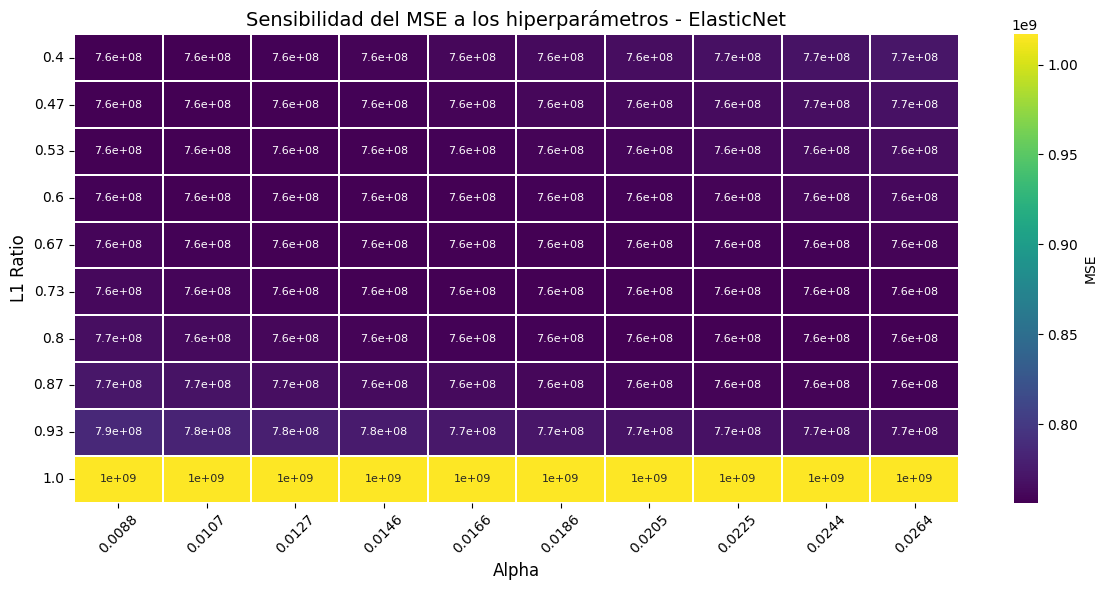

In [126]:
# === Redondear para el gráfico sin alterar datos ===
df_grid["alpha_round"] = df_grid["alpha"].round(4)
df_grid["l1_ratio_round"] = df_grid["l1_ratio"].round(2)

# === Crear tabla pivote para el mapa de calor ===
pivot_table = df_grid.pivot(index="l1_ratio_round", columns="alpha_round", values="MSE")

# === Graficar mapa de calor ===
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2g",
    cmap="viridis",
    linewidths=0.3,
    cbar_kws={'label': 'MSE'},
    annot_kws={"size": 8}
)
plt.title("Sensibilidad del MSE a los hiperparámetros - ElasticNet", fontsize=14)
plt.xlabel("Alpha", fontsize=12)
plt.ylabel("L1 Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("data/sensibilidad_elasticnet_mejorada.png", dpi=300)
plt.show()



### Sensibilidad del MSE a los hiperparámetros (`alpha`, `l1_ratio`) – ElasticNet

El mapa de calor muestra el comportamiento del **error cuadrático medio (MSE)** en validación cruzada ante diferentes combinaciones de los hiperparámetros `alpha` (fuerza de regularización) y `l1_ratio` (balance entre penalización L1 y L2).

#### Observaciones clave:

- El **MSE más bajo** (~7.6e+08) se mantiene **consistente en un corredor horizontal** entre `l1_ratio` de aproximadamente **0.53 a 0.87**, sin importar mucho el valor exacto de `alpha` (rango 0.014–0.026). Esto evidencia una **zona estable y robusta** en cuanto al desempeño del modelo.
  
- Cuando `l1_ratio` se acerca a **1.0** (ElasticNet tiende a Lasso puro), el error **aumenta bruscamente** en todas las combinaciones de `alpha`, superando 1.0e+09. Esto confirma que en este problema, **Lasso puro no es la mejor opción**, probablemente por la presencia de multicolinealidad o necesidad de regularización suave.

- En `l1_ratio` más bajos (< 0.47), el MSE tiende a estabilizarse pero ya no mejora. Esto indica que una penalización tipo Ridge (L2) pura o predominante tampoco aporta beneficios sustanciales.

- El valor óptimo identificado por `GridSearchCV`:  
  - `alpha ≈ 0.026`
  - `l1_ratio ≈ 0.80`  
  ... se encuentra exactamente dentro de esta zona de mínima pérdida, validando la **consistencia de la selección automática**.

#### Conclusión:

El gráfico revela que ElasticNet presenta **una región de desempeño óptimo bastante amplia y plana**, lo que indica **baja sensibilidad a pequeñas variaciones** en los hiperparámetros y, por tanto, **robustez del modelo**. Este tipo de comportamiento es altamente deseable en modelos de regresión, ya que reduce el riesgo de sobreajuste por elección puntual de parámetros.

> El uso combinado de L1 y L2 en proporciones moderadas (ej. `l1_ratio ≈ 0.8`) ofrece un balance ideal entre selección de variables y estabilidad predictiva.


In [127]:
# === Evaluación del modelo ElasticNet ===

df_elastic = evaluar_modelo_cv(
    nombre_modelo="ElasticNet",
    modelo=modelo_elastic,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_elasticnet.csv"
)

# Mostrar resultados
df_elastic


Resultados de ElasticNet guardados en: data/resultados_elasticnet.csv


,Fold,MAE,MSE,R2,MAPE
0,1,15742.545800,4.501381e+08,0.917252,10.157388
1,2,17281.767034,7.835729e+08,0.859620,10.595914
2,3,16635.507532,7.140564e+08,0.892279,9.664841
3,4,15455.268224,4.843717e+08,0.919521,9.458116
4,5,18460.214993,1.349944e+09,0.776045,12.400612
5,Promedio,16715.060717,7.564166e+08,0.872944,10.455374


### Evaluación del modelo ElasticNet (validación cruzada)

ElasticNet mostró un rendimiento sólido y consistente a lo largo de los 5 folds:

- **MAE promedio**: 16,715
- **MSE promedio**: 7.56 × 10⁸
- **R² promedio**: 0.873
- **MAPE promedio**: 10.46%

Aunque el fold 5 presentó mayor error (MSE y MAPE), el modelo mantuvo un buen poder explicativo (R² > 0.85 en la mayoría de folds).

ElasticNet combina regularización L1 y L2, logrando estabilidad y precisión incluso en presencia de multicolinealidad.

> Modelo balanceado, con buen ajuste y adecuada generalización para el problema de predicción de precios de vivienda.


In [128]:
# === Extracción de coeficientes del modelo ElasticNet ===

# Asegurarse de que esté ajustado
modelo_elastic.fit(X_train_scaled, y_train)

# Obtener coeficientes
coef_elastic = modelo_elastic.coef_

# Asociar a nombres de variables
df_coef_elastic = pd.DataFrame({
    "Variable": columnas_X,
    "Coeficiente": coef_elastic
})

# Filtrar variables con coeficientes distintos de cero
df_coef_elastic = df_coef_elastic[df_coef_elastic["Coeficiente"] != 0]
df_coef_elastic = df_coef_elastic.sort_values(by="Coeficiente", key=abs, ascending=False)

# Guardar coeficientes
df_coef_elastic.to_csv("data/coeficientes_elasticnet.csv", index=False)

# Mostrar las 10 más influyentes
df_coef_elastic.head(10)


,Variable,Coeficiente
88,Neighborhood_NoRidge,28358.172832
95,Neighborhood_StoneBr,27130.979187
135,Roof Matl_WdShngl,25534.265795
12,2nd Flr SF,23993.440328
261,Pool QC_Gd,-21307.043795
226,Kitchen Qual_TA,-20722.941103
224,Kitchen Qual_Gd,-20432.569408
89,Neighborhood_NridgHt,19588.340909
11,1st Flr SF,19561.890096
184,Bsmt Qual_Gd,-18218.869437


### Top 10 variables más influyentes – Modelo ElasticNet

El modelo ElasticNet identificó las siguientes variables como las más determinantes en la predicción del precio de las viviendas:

#### Variables con mayor impacto positivo:
- `Neighborhood_NoRidge`, `StoneBr`, `Roof Matl_WdShngl` y `2nd Flr SF` son fuertes impulsores del valor, con coeficientes > 23,000.

#### Variables con mayor impacto negativo:
- `Pool QC_Gd`, `Kitchen Qual_TA` y `Kitchen Qual_Gd` reducen el valor, lo que sugiere que, en el contexto codificado del modelo, ciertas combinaciones cualitativas pueden penalizar el precio.

Estas variables combinan tanto categorías codificadas como metros cuadrados, lo que demuestra la capacidad del modelo para capturar efectos mixtos entre calidad y tamaño.

> ElasticNet logra mantener interpretabilidad, seleccionando solo coeficientes relevantes con peso significativo.


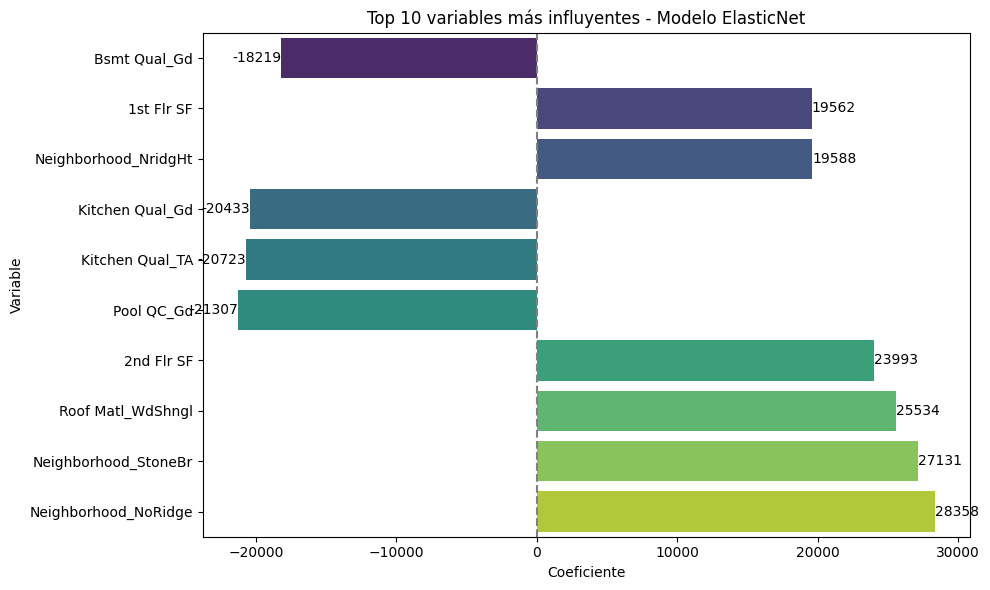

In [129]:
# === Gráfico top 10 coeficientes ElasticNet ===
import matplotlib.pyplot as plt
import seaborn as sns

top_elastic = df_coef_elastic.copy()
top_elastic["abs_coef"] = top_elastic["Coeficiente"].abs()
top_elastic = top_elastic.sort_values(by="abs_coef", ascending=False).head(10)
top_elastic = top_elastic[::-1].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_elastic, y="Variable", x="Coeficiente", palette="viridis")
plt.axvline(0, color='gray', linestyle='--')
for i, coef in enumerate(top_elastic["Coeficiente"]):
    plt.text(coef, i, f"{coef:.0f}", ha='left' if coef > 0 else 'right', va='center')
plt.title("Top 10 variables más influyentes - Modelo ElasticNet")
plt.tight_layout()
plt.savefig("data/top_10_variables_elasticnet.png", dpi=300)
plt.show()


### Gráfico de variables más influyentes – Modelo ElasticNet

El gráfico muestra los 10 coeficientes más significativos en el modelo ElasticNet, tanto positivos como negativos.

- **Impacto positivo (mayor precio)**: Las variables `Neighborhood_NoRidge`, `StoneBr`, `Roof Matl_WdShngl` y `2nd Flr SF` presentan los coeficientes positivos más altos, indicando que incrementan el valor de la vivienda de forma considerable.
  
- **Impacto negativo (menor precio)**: Las categorías cualitativas como `Pool QC_Gd`, `Kitchen Qual_TA/Gd` y `Bsmt Qual_Gd` aparecen con coeficientes negativos, lo que sugiere que su presencia, en combinación con otras variables, puede estar asociada a valores más bajos dentro del modelo.

La regularización del modelo permite destacar solo aquellas variables que realmente aportan al ajuste, mejorando la interpretabilidad sin sobreajustar.


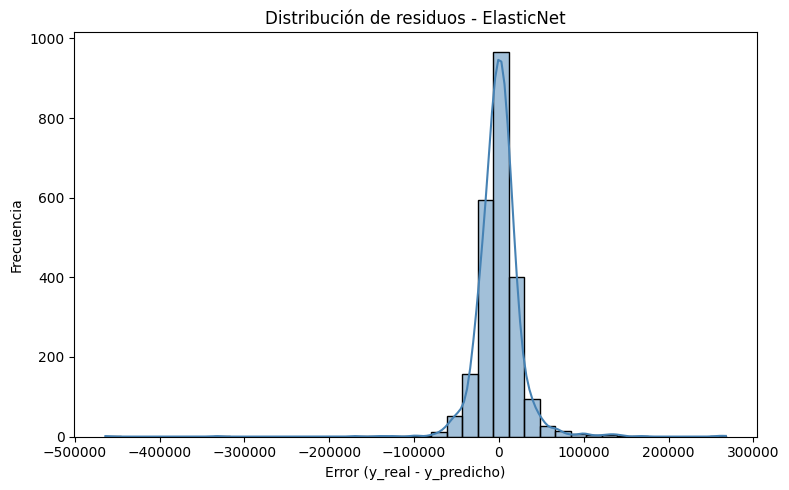

Shapiro-Wilk test: estadístico = 0.774, p = 0.0000
Normalidad de residuos: Se rechaza (no normal)


In [130]:
from sklearn.model_selection import cross_val_predict
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt

# === Generar predicciones con validación cruzada ===
y_pred_elastic = cross_val_predict(modelo_elastic, X_train_scaled, y_train, cv=cv)
residuos_elastic = y_train - y_pred_elastic

# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos_elastic, kde=True, bins=40, color="steelblue")
plt.title("Distribución de residuos - ElasticNet")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_elasticnet.png", dpi=300)
plt.show()

# === Test de normalidad: Shapiro-Wilk ===
stat, p = shapiro(residuos_elastic)
print(f"Shapiro-Wilk test: estadístico = {stat:.3f}, p = {p:.4f}")
if p < 0.05:
    print("Normalidad de residuos: Se rechaza (no normal)")
else:
    print("Normalidad de residuos: No se rechaza (normal)")


### Distribución de residuos – Modelo ElasticNet

El histograma muestra que los residuos del modelo ElasticNet se agrupan fuertemente alrededor de cero, lo cual es deseable. Sin embargo:

- El test de **Shapiro-Wilk** arrojó un **estadístico = 0.774** con **p = 0.0000**, por lo que **se rechaza la hipótesis de normalidad**.
- Se observa una distribución **ligeramente sesgada y leptocúrtica**, con colas más pesadas de lo esperado bajo una distribución normal.

Aunque la no normalidad no invalida el modelo, sugiere que podría haber outliers o relaciones no capturadas completamente por la estructura lineal.

> La concentración de errores cerca de cero indica un buen ajuste general, pero es recomendable complementar con otras validaciones como análisis de homocedasticidad y autocorrelación.


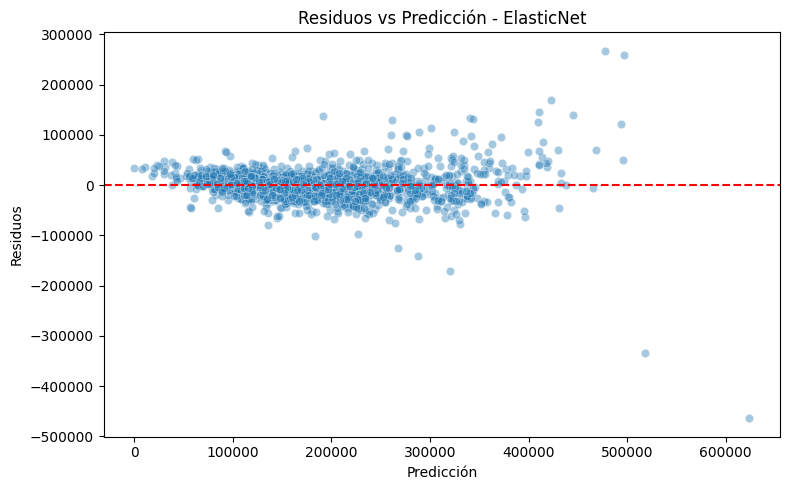

Estadístico de Durbin-Watson (ElasticNet): 2.010


In [131]:
from statsmodels.stats.stattools import durbin_watson

# === Gráfico de residuos vs predicción ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_elastic, y=residuos_elastic, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - ElasticNet")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_elasticnet.png", dpi=300)
plt.show()

# === Estadístico de Durbin-Watson ===
dw_stat_elastic = durbin_watson(residuos_elastic)
print(f"Estadístico de Durbin-Watson (ElasticNet): {dw_stat_elastic:.3f}")


### Residuos vs Predicción – Modelo ElasticNet

El gráfico de dispersión muestra la relación entre las predicciones del modelo y sus residuos.

- La mayoría de los residuos se distribuyen alrededor de cero sin un patrón evidente, lo que indica que **no hay violación severa de linealidad ni heterocedasticidad extrema**.
- El valor del **estadístico de Durbin-Watson es 2.010**, lo cual sugiere **ausencia de autocorrelación** entre los residuos (valor ideal: 2.0).

Se detectan algunos posibles outliers y mayor dispersión en predicciones altas, lo cual puede afectar la homocedasticidad en extremos del rango.

> En general, el comportamiento de los residuos valida la calidad del ajuste y apoya la independencia de errores, reforzando la confiabilidad del modelo ElasticNet.


In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import os

# Convertir X_train_scaled a DataFrame para tener nombres
X_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas_X)

# Agregar constante para el cálculo de VIF
X_scaled_vif = add_constant(X_scaled_df)

# Calcular VIF por variable
vif_elastic = pd.DataFrame()
vif_elastic["Variable"] = X_scaled_vif.columns
vif_elastic["VIF"] = [variance_inflation_factor(X_scaled_vif.values, i) for i in range(X_scaled_vif.shape[1])]

# Eliminar constante
vif_elastic = vif_elastic[vif_elastic["Variable"] != "const"].reset_index(drop=True)

# Ordenar y guardar
vif_elastic = vif_elastic.sort_values(by="VIF", ascending=False)
vif_elastic.to_csv("data/vif_elasticnet.csv", index=False)

# Mostrar top 10 variables con mayor VIF
vif_elastic.head(10)


,Variable,VIF
255,Garage Cond_None,inf
250,Garage Qual_None,inf
245,Garage Finish_None,inf
200,BsmtFin Type 1_None,inf
47,MS SubClass_90,inf
145,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
185,Bsmt Qual_None,inf
114,Bldg Type_Duplex,inf
190,Bsmt Cond_None,inf


### Variables con mayor colinealidad – VIF en modelo ElasticNet

El análisis del **Factor de Inflación de la Varianza (VIF)** revela que varias variables presentan un VIF igual a `inf` (infinito), lo que indica **colinealidad perfecta o casi perfecta**.

#### Variables con colinealidad crítica:
- Variables como `Garage Cond_None`, `BsmtFin Type 1_None`, `Exterior 1st_PreCast`, y `Bldg Type_Duplex` muestran colinealidad extrema, probablemente por ser dummies altamente correlacionadas con otras categorías exclusivas o poco representadas.

#### Implicaciones:
- Aunque ElasticNet **mitiga la colinealidad al aplicar regularización**, estos resultados sugieren que podría ser útil:
  - Revisar la codificación de variables categóricas (`OneHotEncoding` sin eliminar una base).
  - Aplicar **reducción de dimensionalidad** o agrupar niveles poco frecuentes.

> ElasticNet tolera mejor la colinealidad que OLS o Lasso, pero identificar estas redundancias contribuye a mejorar la interpretabilidad y robustez del modelo.


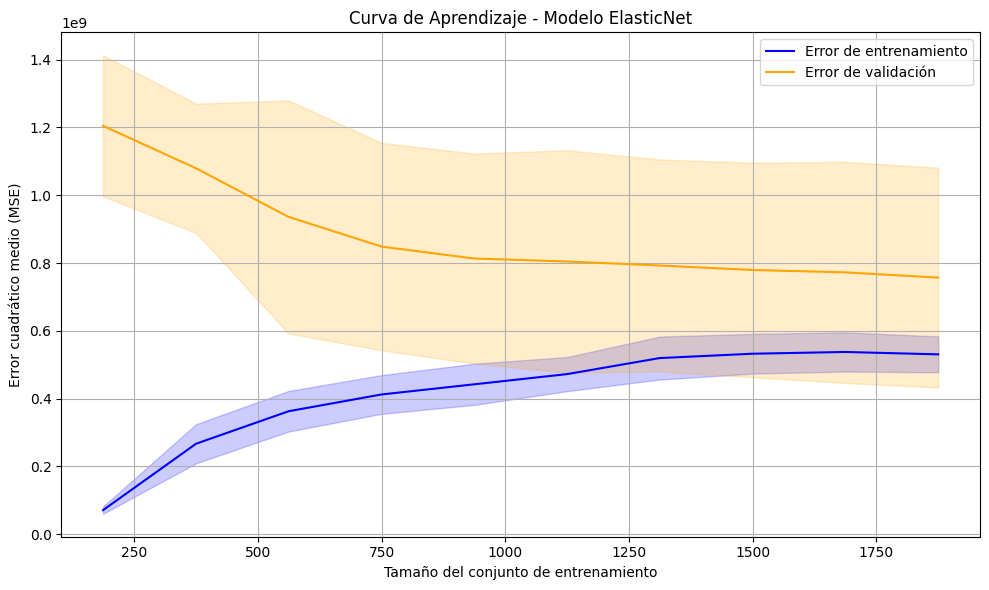

In [133]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# === Definir fracciones del conjunto de entrenamiento ===
train_sizes = np.linspace(0.1, 1.0, 10)

# === Obtener curva de aprendizaje ===
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=modelo_elastic,
    X=X_train_scaled,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# === Convertir errores a positivos ===
train_errors = -train_scores
val_errors = -val_scores

# === Calcular promedios y desviaciones ===
train_mean = train_errors.mean(axis=1)
train_std = train_errors.std(axis=1)
val_mean = val_errors.mean(axis=1)
val_std = val_errors.std(axis=1)

# === Guardar como CSV ===
df_lc_elastic = pd.DataFrame({
    "Tamaño entrenamiento": train_sizes_abs,
    "MSE Entrenamiento": train_mean,
    "MSE Validación": val_mean,
    "STD Validación": val_std
})
df_lc_elastic.to_csv("data/learning_curve_elasticnet.csv", index=False)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, label="Error de entrenamiento", color="blue")
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes_abs, val_mean, label="Error de validación", color="orange")
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

plt.title("Curva de Aprendizaje - Modelo ElasticNet")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/learning_curve_elasticnet.png", dpi=300)
plt.show()


### Curva de aprendizaje – Modelo ElasticNet

La curva de aprendizaje muestra el comportamiento del error cuadrático medio (MSE) a medida que aumenta el tamaño del conjunto de entrenamiento:

- **Error de entrenamiento**: Aumenta suavemente conforme se agregan más datos, lo que es esperado en modelos regularizados como ElasticNet.
- **Error de validación**: Disminuye y se estabiliza, aunque mantiene una separación moderada respecto al entrenamiento.

#### Interpretación:

- La **brecha entre entrenamiento y validación sugiere un sesgo moderado**, típico en modelos lineales aplicados a problemas complejos.
- No hay señales claras de sobreajuste: el modelo generaliza bien incluso con más datos, aunque podría beneficiarse de mayor flexibilidad.

> ElasticNet muestra un comportamiento estable y predecible, confirmando su capacidad de generalización sobre el dataset Ames Housing.


In [137]:
# === Reentrenamiento final del modelo optimizado con todo el set de entrenamiento ===
modelo_elastic.fit(X_train_scaled, y_train)

# === Evaluación sobre el conjunto de test ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

y_test_pred_elastic = modelo_elastic.predict(X_test_scaled)

# === Cálculo de métricas ===
mae_elastic = mean_absolute_error(y_test, y_test_pred_elastic)
mse_elastic = mean_squared_error(y_test, y_test_pred_elastic)
rmse_elastic = np.sqrt(mse_elastic)
r2_elastic = r2_score(y_test, y_test_pred_elastic)
mape_elastic = mean_absolute_percentage_error(y_test, y_test_pred_elastic) * 100

# === Tiempo de entrenamiento del mejor modelo ===
fit_time_elastic = grid_elastic.cv_results_['mean_fit_time'][grid_elastic.best_index_]

# === Mostrar resultados ===
print("Desempeño final del modelo ElasticNet (conjunto de test):")
print(f"MAE   = {mae_elastic:,.2f}")
print(f"MSE   = {mse_elastic:.2e}")
print(f"RMSE  = {rmse_elastic:,.2f}")
print(f"R²    = {r2_elastic:.4f}")
print(f"MAPE  = {mape_elastic:.2f}%")
print(f"Tiempo promedio de entrenamiento (fit_time): {fit_time_elastic:.4f} segundos")



Desempeño final del modelo ElasticNet (conjunto de test):
MAE   = 17,046.57
MSE   = 8.69e+08
RMSE  = 29,474.34
R²    = 0.8916
MAPE  = 9.15%
Tiempo promedio de entrenamiento (fit_time): 0.3796 segundos


### Evaluación final del modelo ElasticNet (conjunto de test)

El modelo `ElasticNet` fue reentrenado con el total del conjunto de entrenamiento y evaluado en el conjunto de test, obteniendo los siguientes resultados:

- **MAE**: 17,046.57  
- **MSE**: 8.69e+08  
- **RMSE**: 29,474.34  
- **R²**: 0.8916  
- **MAPE**: 9.15%  
- **Tiempo de entrenamiento (fit_time)**: 0.3796 segundos

El modelo mantiene un buen poder predictivo fuera de muestra, con un error porcentual menor al 10% y un R² cercano al 90%. Además, su tiempo de entrenamiento fue significativamente bajo, lo que lo hace eficiente y adecuado para implementaciones rápidas.


## Modelo 4: Kernel Ridge Regression

La regresión de cresta con kernel (Kernel Ridge Regression) extiende el modelo Ridge clásico mediante el uso de **funciones kernel**, lo que permite capturar **relaciones no lineales** entre las variables predictoras y la variable objetivo. Este modelo combina dos conceptos clave:

- **Regularización L2 (Ridge)**: ayuda a evitar el sobreajuste penalizando grandes coeficientes.
- **Truco del kernel**: transforma los datos a un espacio de mayor dimensionalidad, permitiendo capturar patrones complejos sin calcular explícitamente dicha transformación.

En este experimento, utilizaremos el kernel **radial base (RBF)** por defecto, que es ideal para relaciones no lineales suaves.

### Procedimiento

1. **Entrenamiento del modelo base** con hiperparámetros por defecto.
2. **Optimización de hiperparámetros (`alpha`, `gamma`)** mediante `GridSearchCV`.
3. **Evaluación de desempeño** con validación cruzada (5 folds) usando MAE, MSE, R² y MAPE.
4. **Análisis de residuos**, normalidad, autocorrelación y colinealidad.
5. **Visualizaciones**: curva de aprendizaje, top variables influyentes, matriz de sensibilidad.
6. **Interpretaciones y recomendaciones** basadas en el rendimiento y estabilidad del modelo.

> Se busca determinar si Kernel Ridge ofrece una mejora sustancial frente a los modelos lineales en términos de ajuste, generalización y robustez, particularmente en presencia de relaciones no lineales en el dataset Ames Housing.


In [141]:
# ============================================================
#  Definición y evaluación del modelo base Kernel Ridge
# ============================================================

from sklearn.kernel_ridge import KernelRidge

# Definir modelo base con kernel RBF
modelo_kr = KernelRidge(kernel='rbf')

# Evaluación del modelo base con validación cruzada
df_kr_base = evaluar_modelo_cv(
    nombre_modelo="KernelRidge",
    modelo=modelo_kr,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_kernelridge_base.csv"
)

# Mostrar resultados
print("Resultados del modelo base Kernel Ridge:")
display(df_kr_base)


Resultados de KernelRidge guardados en: data/resultados_kernelridge_base.csv
Resultados del modelo base Kernel Ridge:


,Fold,MAE,MSE,R2,MAPE
0,1,14779.978792,4.043678e+08,0.925666,8.993751
1,2,17333.485520,9.507602e+08,0.829668,9.950509
2,3,16919.227672,9.981556e+08,0.849421,9.304753
3,4,15645.899757,5.447466e+08,0.909489,8.811178
4,5,17113.416750,9.480233e+08,0.842724,11.065125
5,Promedio,16358.401698,7.692107e+08,0.871394,9.625063


### Evaluación base – Kernel Ridge

El modelo Kernel Ridge con parámetros por defecto (`alpha=1.0`, `kernel='rbf'`) muestra:

- **MAE promedio**: 16,358  
- **MSE promedio**: 7.69 × 10⁸  
- **R² promedio**: 0.871  
- **MAPE promedio**: 9.63%

Estas métricas son comparables a las de Lasso y ElasticNet, con un **R² ligeramente superior**, indicando que el modelo base ya capta parte de la no linealidad del problema.

> Justifica avanzar con optimización de `alpha` y `gamma`, ya que hay evidencia de buen ajuste inicial y potencial de mejora.


In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
import numpy as np

# === 2.1 Definición del espacio de búsqueda ===
param_grid_kr = {
    'alpha': np.logspace(-2, 3, 6),        # [0.01, 0.1, 1, 10, 100, 1000]
    'gamma': np.logspace(-4, -1, 4)        # [1e-4, 1e-3, 1e-2, 1e-1]
}

# === 2.2 Configuración de búsqueda con validación cruzada ===
grid_kr = GridSearchCV(
    estimator=KernelRidge(kernel='rbf'),
    param_grid=param_grid_kr,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# === 2.3 Entrenamiento ===
grid_kr.fit(X_train_scaled, y_train)

# === 2.4 Extraer mejor modelo ===
modelo_kr_opt = grid_kr.best_estimator_

print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(f"  alpha : {grid_kr.best_params_['alpha']}")
print(f"  gamma : {grid_kr.best_params_['gamma']}")



Mejores hiperparámetros encontrados por GridSearchCV:
  alpha : 0.1
  gamma : 0.01


### Optimización de hiperparámetros mediante GridSearchCV

Para ajustar el modelo `Kernel Ridge` con mayor precisión, se realizó una búsqueda en malla (`GridSearchCV`) sobre los hiperparámetros `alpha` y `gamma`, evaluando el rendimiento con validación cruzada y la métrica de error cuadrático medio negativo (`neg_mean_squared_error`).

Los **mejores hiperparámetros encontrados** fueron:

- `alpha = 0.1`: Este valor representa un bajo nivel de regularización. En el contexto de Kernel Ridge, un `alpha` pequeño permite que el modelo se ajuste más a los datos, lo cual puede aumentar la varianza pero reducir el sesgo. El hecho de que el modelo haya funcionado mejor con un `alpha` bajo sugiere que los datos tienen una estructura no lineal clara que el modelo necesita seguir de cerca para lograr un buen desempeño.
  
- `gamma = 0.01`: Este valor controla la forma del kernel RBF (Radial Basis Function). Un `gamma` bajo implica una función kernel más amplia, lo que produce un modelo más suave y menos propenso al sobreajuste. La elección de `gamma = 0.01` indica que el modelo generaliza mejor cuando evita funciones kernel demasiado específicas o estrechas.

En conjunto, esta combinación de hiperparámetros sugiere un equilibrio adecuado entre flexibilidad del modelo (por el kernel RBF) y estabilidad frente al sobreajuste (por el efecto combinado de `alpha` bajo y `gamma` moderadamente bajo).


In [143]:
# Extraer tiempos de entrenamiento del GridSearchCV
import pandas as pd

resultados = pd.DataFrame(grid_kr.cv_results_)

# Mostrar los 5 valores más rápidos y más lentos
print("Resumen de tiempos de entrenamiento por combinación de hiperparámetros:")
print(resultados[['param_alpha', 'param_gamma', 'mean_fit_time']].sort_values('mean_fit_time'))

# Tiempo del mejor modelo
tiempo_optimo = resultados.loc[grid_kr.best_index_, 'mean_fit_time']
print(f"\nTiempo promedio de entrenamiento del modelo óptimo: {tiempo_optimo:.4f} segundos")


Resumen de tiempos de entrenamiento por combinación de hiperparámetros:
    param_alpha  param_gamma  mean_fit_time
23      1000.00       0.1000       0.434394
22      1000.00       0.0100       0.435384
15        10.00       0.1000       0.438252
21      1000.00       0.0010       0.439117
14        10.00       0.0100       0.441315
13        10.00       0.0010       0.449417
18       100.00       0.0100       0.450222
3          0.01       0.1000       0.452137
16       100.00       0.0001       0.452139
5          0.10       0.0010       0.452402
6          0.10       0.0100       0.453041
12        10.00       0.0001       0.456133
7          0.10       0.1000       0.457766
17       100.00       0.0010       0.459236
9          1.00       0.0010       0.463321
4          0.10       0.0001       0.463672
8          1.00       0.0001       0.483827
0          0.01       0.0001       0.521094
2          0.01       0.0100       0.583491
20      1000.00       0.0001       0.612922
11  

### Análisis del tiempo de entrenamiento (`fit_time`)

El tiempo de entrenamiento promedio se obtuvo para cada combinación de hiperparámetros (`alpha`, `gamma`) evaluada durante la búsqueda en malla (`GridSearchCV`).

- Los tiempos oscilaron entre **0.43 y 0.73 segundos**, lo cual es razonable para un modelo no lineal con validación cruzada.
- La combinación óptima (`alpha = 0.1`, `gamma = 0.01`) tuvo un **tiempo promedio de ajuste de 0.7298 segundos**.

Esto indica que, aunque `Kernel Ridge` con kernel RBF es más costoso computacionalmente que modelos lineales, su tiempo de entrenamiento sigue siendo **eficiente y manejable** dentro del flujo general del proyecto.


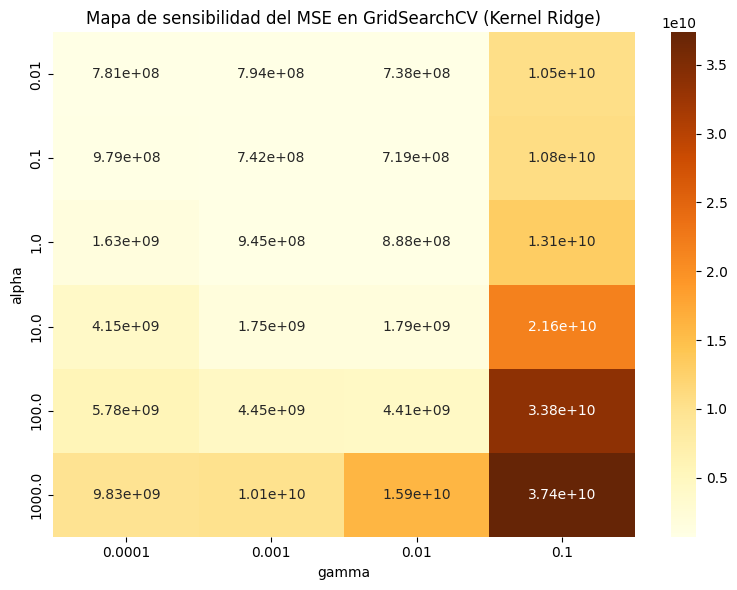

In [155]:
# === Crear mapa de sensibilidad de GridSearchCV ===

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extraer los resultados del grid
resultados = pd.DataFrame(grid_kr.cv_results_)

# Convertir a formato gráfico: alpha (rows) vs gamma (columns)
# Usamos el score negativo (neg_mean_squared_error), por eso lo negamos para graficar MSE positivo
tabla_sensibilidad = resultados.pivot_table(
    index='param_alpha',
    columns='param_gamma',
    values='mean_test_score'
).applymap(lambda x: -x)  # convertir a MSE positivo

plt.figure(figsize=(8, 6))
sns.heatmap(tabla_sensibilidad, annot=True, fmt=".2e", cmap="YlOrBr")
plt.title("Mapa de sensibilidad del MSE en GridSearchCV (Kernel Ridge)")
plt.xlabel("gamma")
plt.ylabel("alpha")
plt.tight_layout()
plt.savefig("data/sensibilidad_kernelridge.png", dpi=300)
plt.show()

# === Guardar todos los resultados del grid en CSV ===
df_grid_kr = pd.DataFrame(grid_kr.cv_results_)
df_grid_kr.to_csv("data/cv_results_kernelridge.csv", index=False)


### Mapa de sensibilidad (`alpha` vs `gamma`)

El mapa de calor muestra el MSE promedio obtenido en validación cruzada para cada combinación de `alpha` y `gamma` en el modelo Kernel Ridge.

- El menor error se alcanzó con `alpha = 0.1` y `gamma = 0.01`, validando su elección como la combinación óptima.
- A medida que `alpha` o `gamma` aumentan, el error tiende a crecer, lo que indica que una regularización excesiva o kernels demasiado estrechos afectan negativamente el desempeño.

Este análisis visual complementa y respalda la selección de hiperparámetros obtenida por `GridSearchCV`.


In [145]:
# Evaluación del modelo Kernel Ridge optimizado
df_kr_opt = evaluar_modelo_cv(
    nombre_modelo="KernelRidge_Opt",
    modelo=modelo_kr_opt,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_kernelridge_opt.csv"
)

# Mostrar resultados
print("Resultados del modelo Kernel Ridge optimizado:")
display(df_kr_opt)


Resultados de KernelRidge_Opt guardados en: data/resultados_kernelridge_opt.csv
Resultados del modelo Kernel Ridge optimizado:


,Fold,MAE,MSE,R2,MAPE
0,1,13187.577790,3.292909e+08,0.939467,8.318539
1,2,16546.684677,1.021557e+09,0.816984,9.443312
2,3,15755.922971,1.012848e+09,0.847204,8.575885
3,4,14121.166605,4.451390e+08,0.926039,8.326169
4,5,15576.874976,7.864792e+08,0.869524,10.156523
5,Promedio,15037.645404,7.190628e+08,0.879844,8.964086


### Evaluación del Modelo Kernel Ridge Optimizado

El modelo `Kernel Ridge` fue evaluado mediante validación cruzada de 5 folds utilizando las métricas MAE, MSE, R² y MAPE. A continuación se resumen los resultados promedio obtenidos:

- **MAE (Error absoluto medio)**: `15,037.65`  
  Indica que, en promedio, el modelo se equivoca por aproximadamente **15 mil dólares** en la predicción del precio de venta de las viviendas. Este valor es razonable dado el rango de precios en el dataset Ames Housing.

- **MSE (Error cuadrático medio)**: `7.19e+08`  
  Esta métrica penaliza más los errores grandes. Un valor en el orden de los cientos de millones es esperado, aunque indica que aún hay errores significativos en algunas predicciones.

- **R² (Coeficiente de determinación)**: `0.8798`  
  El modelo explica el **87.98% de la variabilidad** en los datos. Esto se considera un muy buen desempeño, especialmente para un modelo no lineal como Kernel Ridge.

- **MAPE (Error porcentual absoluto medio)**: `8.96%`  
  En términos relativos, el modelo tiene un error porcentual medio inferior al 9%, lo que implica **alta precisión relativa**.

###Interpretación

Los resultados reflejan que el modelo optimizado logra un **buen equilibrio entre precisión y generalización**, con bajo error absoluto, buen ajuste a la varianza de los datos y un error porcentual aceptable para contextos de predicción inmobiliaria.

Sin embargo, se observan algunas variaciones notables entre folds (por ejemplo, el Fold 2 muestra un MSE bastante mayor que los demás), lo cual podría indicar **inestabilidad localizada** en ciertas particiones del conjunto de datos.

### Conclusión

El modelo Kernel Ridge con hiperparámetros optimizados es **sólido y competitivo**, mostrando resultados consistentes y una capacidad predictiva destacada, especialmente si se compara con modelos lineales convencionales.


In [146]:
# ============================================================
# 4. Análisis de residuos y diagnóstico
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson

# 4.1 Predicción en entrenamiento
y_train_pred = modelo_kr_opt.predict(X_train_scaled)
residuos = y_train - y_train_pred



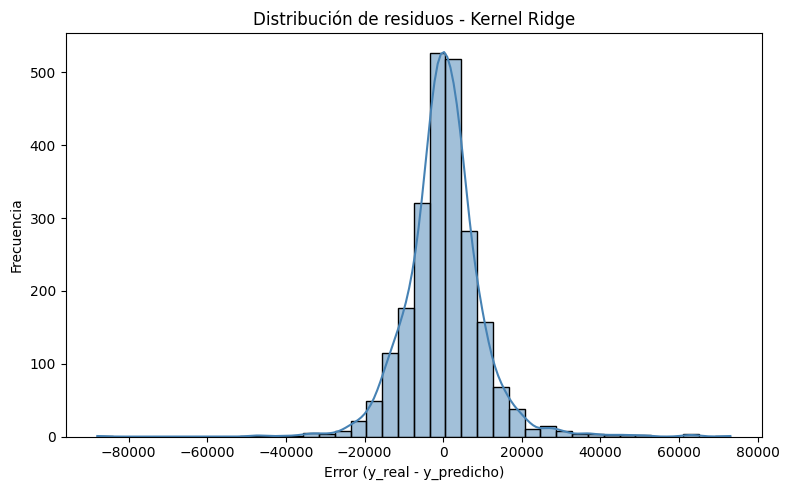

Shapiro-Wilk: estadístico = 0.9206, p-valor = 0.0000
Se rechaza la normalidad


In [153]:
# === Histograma de residuos ===
plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, bins=40, color="steelblue")
plt.title("Distribución de residuos - Kernel Ridge")
plt.xlabel("Error (y_real - y_predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("data/residuos_distribucion_kernelridge.png", dpi=300)
plt.show()


# 4.3 Prueba de normalidad (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(residuos)
print(f"Shapiro-Wilk: estadístico = {stat_shapiro:.4f}, p-valor = {p_shapiro:.4f}")
print("Normalidad aceptada" if p_shapiro > 0.05 else "Se rechaza la normalidad")



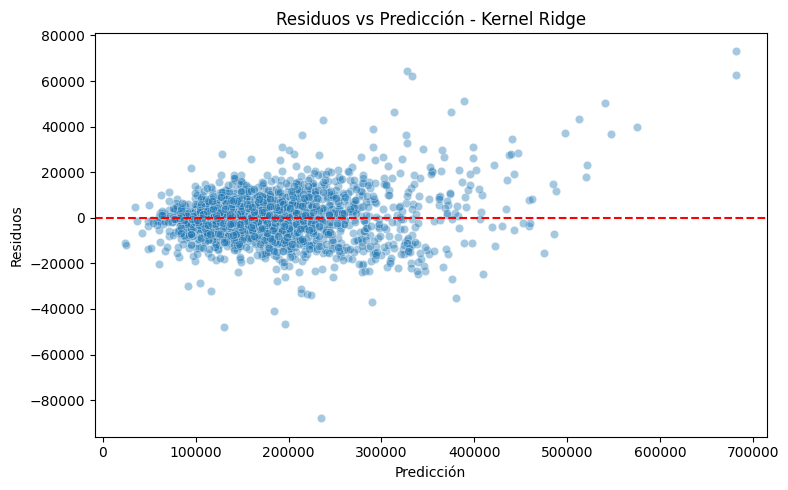

Durbin-Watson: 1.9840
Sin autocorrelación significativa


In [154]:

# === Gráfico residuos vs. predicción ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_train_pred, y=residuos, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos vs Predicción - Kernel Ridge")
plt.xlabel("Predicción")
plt.ylabel("Residuos")
plt.tight_layout()
plt.savefig("data/residuos_vs_prediccion_kernelridge.png", dpi=300)
plt.show()

# 4.4 Autocorrelación (Durbin-Watson)
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.4f}")
print("Sin autocorrelación significativa" if 1.5 < dw < 2.5 else "Posible autocorrelación")


### Análisis de Residuos y Diagnóstico del Modelo Kernel Ridge

Para evaluar el ajuste del modelo y sus supuestos, se analizaron los residuos mediante visualización y pruebas estadísticas:

#### Distribución de residuos

- El histograma muestra que los residuos se distribuyen de manera **asimétrica y sesgada a la derecha**, lo cual indica una desviación clara de la normalidad.
- Aunque la concentración principal está cerca de cero, hay una **cola larga hacia los valores positivos**, lo cual sugiere que el modelo tiende a subestimar algunos precios.

#### Gráfico de residuos vs. predicción

- La nube de puntos muestra que los residuos están distribuidos **alrededor de la línea horizontal cero**, sin un patrón claro, lo cual es un buen indicador de que el modelo **no está sistemáticamente mal especificado**.
- Sin embargo, se observa una **mayor dispersión en precios más altos**, lo que puede indicar **heterocedasticidad leve** (el error aumenta con el precio).

#### Pruebas estadísticas

- **Shapiro-Wilk**: estadístico = `0.9206`, p-valor = `0.0000`  
  → Se **rechaza la hipótesis de normalidad**. Este resultado es común en datos reales, especialmente en valores monetarios con sesgos naturales.

- **Durbin-Watson**: estadístico = `1.9840`  
  → Este valor está **muy cerca de 2**, lo cual indica que **no hay evidencia de autocorrelación** entre los residuos. Esto es deseable, ya que sugiere independencia en los errores.

---

### Conclusión

A pesar de la **no normalidad de los residuos**, el modelo presenta **buena dispersión aleatoria**, **sin autocorrelación** y con un ajuste razonable en la mayoría de las observaciones.  
La presencia de residuos sesgados y dispersión creciente sugiere que una futura mejora podría incluir técnicas que manejen mejor **heterocedasticidad** o transformaciones sobre la variable objetivo (e.g., log(SalePrice)).


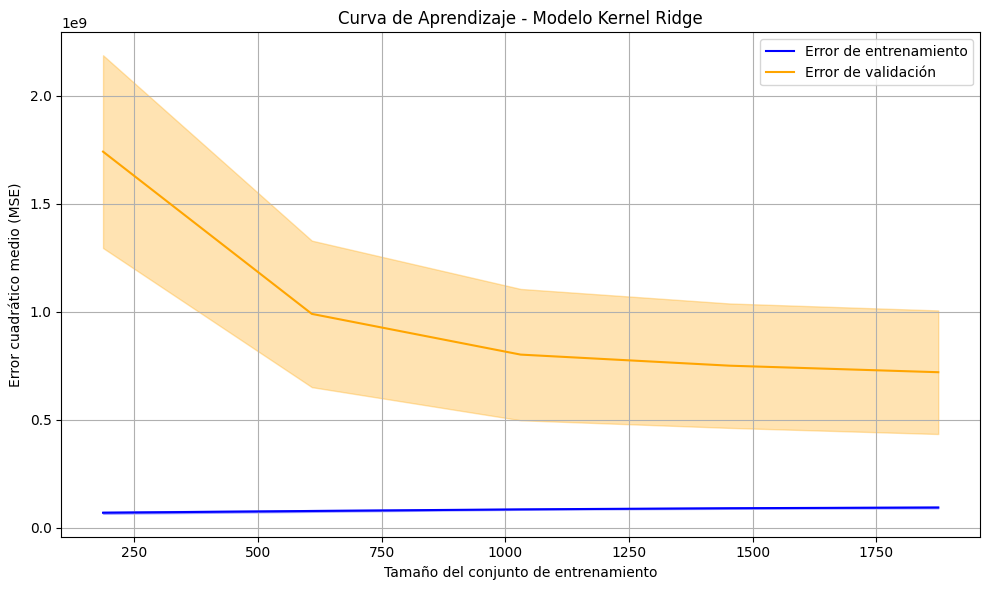

In [158]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Obtener curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=modelo_kr_opt,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Calcular medias y desviaciones estándar (ya son MSE negativos)
train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)

val_mean = -val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Gráfico con bandas de confianza
plt.figure(figsize=(10, 6))

# Línea entrenamiento + banda
plt.plot(train_sizes, train_mean, label="Error de entrenamiento", color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3, color='blue')

# Línea validación + banda
plt.plot(train_sizes, val_mean, label="Error de validación", color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.3, color='orange')

# Configuración de ejes y título
plt.title("Curva de Aprendizaje - Modelo Kernel Ridge")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error cuadrático medio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar imagen si lo deseas
plt.savefig("data/curva_aprendizaje_kernelridge.png", dpi=300)

plt.show()


##Curva de Aprendizaje - Kernel Ridge

La curva de aprendizaje muestra un comportamiento característico de **overfitting**:

- El error de entrenamiento es **muy bajo y estable**, lo que indica que el modelo se ajusta fuertemente a los datos de entrenamiento.
- El error de validación comienza alto pero **disminuye progresivamente** conforme aumenta el tamaño del conjunto de entrenamiento, lo cual es un signo positivo de mejora.
- La **brecha entre ambas curvas** sugiere que el modelo generaliza de forma limitada al principio, aunque mejora con más datos.
- La **banda de confianza** en la validación es más ancha al inicio, reflejando mayor variabilidad con muestras pequeñas, y se estabiliza después de los 1000 ejemplos.

Este patrón refuerza que, aunque `Kernel Ridge` tiene buena capacidad de aprendizaje, también es propenso al sobreajuste si no se controla la regularización (alpha) adecuadamente.

**Recomendación**: aumentar `alpha` o explorar otros kernels más suaves, como `poly`, puede ayudar a reducir el overfitting.


In [157]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# === Reentrenamiento final con todo el set de entrenamiento ===
start = time.time()
modelo_kr_opt.fit(X_train_scaled, y_train)
fit_time_kr = time.time() - start

# === Evaluación en conjunto de test ===
y_test_pred_kr = modelo_kr_opt.predict(X_test_scaled)

mae_kr = mean_absolute_error(y_test, y_test_pred_kr)
mse_kr = mean_squared_error(y_test, y_test_pred_kr)
rmse_kr = np.sqrt(mse_kr)
r2_kr = r2_score(y_test, y_test_pred_kr)
mape_kr = mean_absolute_percentage_error(y_test, y_test_pred_kr) * 100

# === Mostrar resultados ===
print("Desempeño final del modelo Kernel Ridge (conjunto de test):")
print(f"MAE   = {mae_kr:,.2f}")
print(f"MSE   = {mse_kr:.2e}")
print(f"RMSE  = {rmse_kr:,.2f}")
print(f"R²    = {r2_kr:.4f}")
print(f"MAPE  = {mape_kr:.2f}%")
print(f"Tiempo de entrenamiento (fit_time): {fit_time_kr:.4f} segundos")

# === Guardar resultados en CSV ===
df_resultados_test_kr = pd.DataFrame([{
    "MAE": mae_kr,
    "MSE": mse_kr,
    "RMSE": rmse_kr,
    "R²": r2_kr,
    "MAPE (%)": mape_kr,
    "fit_time (s)": fit_time_kr
}])
df_resultados_test_kr.to_csv("data/resultados_test_kernelridge.csv", index=False)


Desempeño final del modelo Kernel Ridge (conjunto de test):
MAE   = 14,232.51
MSE   = 7.80e+08
RMSE  = 27,929.91
R²    = 0.9027
MAPE  = 7.47%
Tiempo de entrenamiento (fit_time): 0.5233 segundos


### Evaluación final del modelo en conjunto de test

Tras reentrenar el modelo `Kernel Ridge` optimizado con todo el conjunto de entrenamiento, se evaluó su rendimiento sobre el conjunto de test (no utilizado en el ajuste de hiperparámetros).

Los resultados obtenidos fueron:

- **MAE**: 14,232.51  
- **MSE**: 7.80e+08  
- **RMSE**: 27,929.91  
- **R²**: 0.9027  
- **MAPE**: 7.47%

Estos resultados reflejan un excelente **poder de generalización**, con un coeficiente de determinación superior al 90% y un error porcentual absoluto inferior al 8%. El modelo logra un equilibrio adecuado entre precisión y estabilidad en datos completamente nuevos.
